# **Assignment 3:** Long Short Term Memory (LSTM) for Time Series

#### **Course:** SCC0270-SCC5809 Artificial Neural Networks

#### **Professor:** Moacir Antonelli Ponti

#### **Assistant:** Márcus Vinícius Lobo Costa


---
### **Personal Info:**
*   **Student(s):**
    *   Amanda Araujo Silva - nº USP: 10260441

In this assignment you will practice building a LSTM for predicting stock price on the Google Colab environment and with PyTorch. The goals of this practice are the following:

- Understand how to set up a time-series prediction problem for neural networks
- Implement a LSTM-based network to solve such problem
- Experiment with different LSTM architectures

# **1. Dataset**


We will be using a dataset IBM stock price.

## **Preparing Task:** Upload your IBM stock price dataset

Upload your file `ibm.us.txt` into the cell bellow.

In [1]:
# you can upload the file using the following code, or manually
from google import colab as cl

file_upload = cl.files.upload()

Saving ibm.us.txt to ibm.us.txt


In [128]:
import pandas as pd

dataset = pd.read_csv('/content/ibm.us.txt', index_col='Date', parse_dates=True,
                      usecols=['Date', 'Close'], na_values=['nan'])

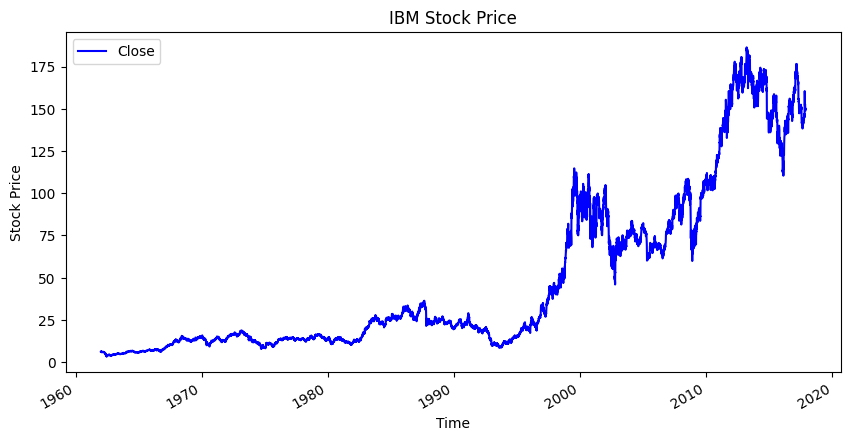

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

dataset.plot(figsize=(10, 5), color = 'blue')
plt.title("IBM Stock Price")
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.show()

### Time series interval:

- For this assignment, we will only be using the years 2010 to 2017 for stock prices.

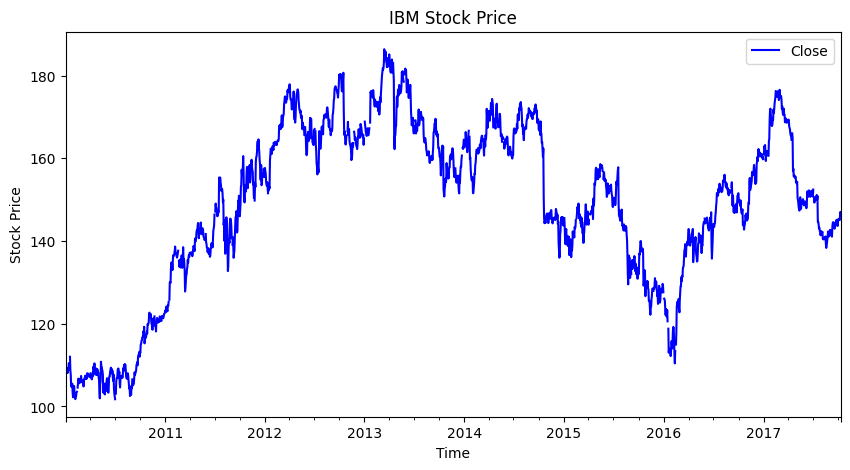

In [130]:
dates = pd.date_range('2010-01-04','2017-10-11', freq='B')
df = pd.DataFrame(index=dates)
dataset = df.join(dataset)

dataset[['Close']].plot(figsize=(10, 5), color = 'blue')
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.title("IBM Stock Price")
plt.show()

**Feature Scaling**

Transform features by scaling each feature to a given range. Here we are scaling it to the interval -1 to 1.

In [131]:
from sklearn.preprocessing import MinMaxScaler

dataset = dataset.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset['Close'] = scaler.fit_transform(dataset['Close'].values.reshape(-1, 1))

In [132]:
#Processed data
print(dataset.head())

               Close
2010-01-04 -0.790830
2010-01-05 -0.822264
2010-01-06 -0.838809
2010-01-07 -0.847554
2010-01-08 -0.822264


In [7]:
print(dataset.shape)

(2028, 1)


**Create Datasets**

Preparing ou dataset for `training` and `validation` sets.

The datasets are defined as "sliding window" points, so that each time series subinterval is used to predict a point in the future.

For example we can use the values of 7 days to predict the value of the 8th day. In this case we have a lookback of 8.


In [23]:
import torch
import numpy as np
from torchsummary import summary

def create_split_data(ts, lookback, test_split_size):
  """ Function to create a supervised dataset from time series
      Parameters:
      ts : list or Series with time series values
      lookback : defines how many points backwards
                 so that the lookback-1 points are going
                 to be used to predict the next one
      test_split_size : value between 0-1 defining the
                        proportion of the series to use as test set
  """

  data_raw = ts.to_numpy() #Convert to numpy array
  data = []

  # create all possible sequences of length equal to lookback
  for index in range(len(data_raw) - lookback):
      # each observation t will contain the 'lookback' previous points
      data.append(data_raw[index: index + lookback])

  data = np.array(data)

  # compute training and testing sizes
  test_set_size = int(np.round(test_split_size*data.shape[0]))
  train_set_size = data.shape[0] - (test_set_size)

  # arrays for recurrent nets have 3 dimensions:
  # - number of samples (for training, testing)
  # - number of time steps (defined by the lookback parameter)
  # - number of features (for a single time series, this will be 1)

  # the x and y will have a displacement so that
  # each point from 0 to t-1 is used to predict the point t
  x_train = data[:train_set_size, :-1, :]
  y_train = data[:train_set_size, -1, :]

  x_test = data[train_set_size:, :-1, :]
  y_test = data[train_set_size:, -1, :]

  # Converts into Pytorch tensors
  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train = torch.from_numpy(y_train).type(torch.Tensor)
  y_test = torch.from_numpy(y_test).type(torch.Tensor)

  return [x_train, y_train, x_test, y_test]

### **Task 1:** (0.5 pts) Use the provided function to define the training and testing datasets with lookback of 30 days and 20% of the time series for testing

In [24]:
## your code here
x_train, y_train, x_test, y_test = create_split_data(dataset, 30, 0.2)

# **2. Building our LSTM Model**

### **Architecture Review**

- `Long Short Term Memory networks` – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png"
     alt="LSTM Chain"
     style="float: left; margin-right: 10px; width:100px; height: 100px;" />

### Network Definition

Study the base code for the class below. See that the forward pass is a little different from other networks, since we want to backpropagate only the current values in the sequence. Also in both training and inference times, initializing these states at each forward pass ensures that the model starts fresh for each new sequence it processes and updates the states according to the information in the sequence only. This allows the model to learn and retain information over time as it processes sequential data.

### **Task 2:** (1.5 pt)

1. Complete the class with the required code so that we have an LSTM network with:
- At least one layer `num_layers = 1`, with the number of LSTM units (`hidden_size`) fixed for all layers
- A linear output layer (the output value will be used as the predicted value)
- Allow the number of layers and number of dimensions to be defined at the moment of network initialization (you can use just a single LSTM for that since the `hidden_size` will be equal for all layers and pytorch allows to stack layers in a single `nn.LSTM()` call)

2. Initialize one network using input and output dimensions = 1, then 1 layer with 32 LSTM units. Print the resulting model.

In [133]:
import torch.nn as nn

#Reference LSTM pytorch: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

class LSTM_base(nn.Module):

  def __init__(self, input_dim, hidden_size, num_layers, output_dim):
    super(LSTM_base, self).__init__()

    self.hidden_size = hidden_size  #Hidden dimensions
    self.num_layers = num_layers  #Number of hidden layers

    # complete with lstm and linear output layers
    self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(in_features= hidden_size, out_features= output_dim)


  def forward(self, x):
    # Initialize hidden state with zeros
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #hidden state
    # Initialize cell state
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #cell state

    out, (hn, cn) = self.lstm(x, (h0, c0))

    # get as output only the hidden layer of the last stage
    out = self.fc(out[:, -1, :])

    return out

In [139]:
## instantiate the model and print it
model = LSTM_base(1, 32, 1, 1) #input_dim, hidden_size, num_layers, output_dim
print(model)

LSTM_base(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


# **3.Training**

### **Task 3:** (3 pts) Training the LSTM model

Study the base function below, and complete with the required code. The function first trains the model, and then predict the values for a testing dataset.

Use the MSE Loss and the Adam optimizer with an initial learning rate of 0.005, and run a training for 50 epochs.

In [140]:
def training_and_evaluate(model, epochs, loss_function, optimizer, X_train, y_train, X_test, verbose=True):
  """Function to train a model and evaluate it
     Params:
      model - instantiated model
      epochs - number of epochs
      loss_function - loss function object (torch) to train the model
      optimizer - optimizer object (torch) to train the model
      X_train, y_train - training dataset
      X_test - testing dataset
      verbose - Flag to allow print the loss at each epoch (default = True)
    Returns:
      history of the training, predictions for training, predictions for testing
      ex: history, y_pred_train, y_pred_test
  """
  history_train = np.zeros(epochs)

  #Put your model in training mode
  model.train()

  for epoch in range(epochs):

    #Forward pass
    output = model(x_train)

    #Loss function/criterion
    loss = loss_function(output, y_train)

    if verbose:
        print(f"Epoch [{epoch + 1}|{epochs}] Loss: {loss.item()}")
    history_train[epoch] = loss.item()

    #Clean the gradient
    optimizer.zero_grad()
    loss.backward()

    #Update parameters
    optimizer.step()

  # model validation mode
  model.eval()
  with torch.no_grad():
    # Make predictions for the training and testing
    prediction_train = model(X_train)
    prediction_test = model(X_test)

  return history_train, prediction_train, prediction_test


In [141]:
# specify training parameters and functions
# use `training_and_evaluate` function

"MSE Loss and the Adam optimizer with an initial learning rate of 0.005, and run a training for 50 epochs."

epochs = 50
loss_function = nn.MSELoss() #Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

history_train, prediction_train, prediction_test = training_and_evaluate(model, epochs, loss_function, optimizer, x_train, y_train, x_test, verbose=True)

Epoch [1|50] Loss: 0.2974155843257904
Epoch [2|50] Loss: 0.263237327337265
Epoch [3|50] Loss: 0.23244553804397583
Epoch [4|50] Loss: 0.20407411456108093
Epoch [5|50] Loss: 0.1780734658241272
Epoch [6|50] Loss: 0.1554795205593109
Epoch [7|50] Loss: 0.13822810351848602
Epoch [8|50] Loss: 0.12653128802776337
Epoch [9|50] Loss: 0.11491072922945023
Epoch [10|50] Loss: 0.0948818027973175
Epoch [11|50] Loss: 0.06761126965284348
Epoch [12|50] Loss: 0.042985107749700546
Epoch [13|50] Loss: 0.026530250906944275
Epoch [14|50] Loss: 0.017859341576695442
Epoch [15|50] Loss: 0.015667986124753952
Epoch [16|50] Loss: 0.020202890038490295
Epoch [17|50] Loss: 0.029692936688661575
Epoch [18|50] Loss: 0.03483778238296509
Epoch [19|50] Loss: 0.02849920280277729
Epoch [20|50] Loss: 0.018865207210183144
Epoch [21|50] Loss: 0.01320352777838707
Epoch [22|50] Loss: 0.011152139864861965
Epoch [23|50] Loss: 0.010428174398839474
Epoch [24|50] Loss: 0.01004346739500761
Epoch [25|50] Loss: 0.01005138922482729
Epoch 

#4. **Evaluating and Visualizing the Results**

Study the function `model_performance` below, completing the parts needed for:
- using the scaler to inverse transform the predicted training and testing series
- computing the root of the mean squared error for the training predicted data, and the testing predicted data
- visualize the

### **Task 4:** (2 pt) Visualize the results as follows:
- Plot the training history (the loss values along epochs)
- Use the function `model_performance` to plot the Root Mean Squared Error Values for both training and testing sets, as weel as plotting the test time series actual values and the predicted values.

In [142]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np

def model_performance(y_train, y_hat_train, y_test, y_hat_test, num_epochs):
    """Visualize series and predicted series, and evaluate model with RMSE
       Params:
          y_train - real training series
          y_hat_train - predicted training series
          y_test - real testing series
          y_hat_test - predicted training series
    """
    # Apply the reverse transformation on the data
    y_hat_train_rev = scaler.inverse_transform(y_hat_train.detach().numpy()) #complete
    ## complete with your code here
    y_hat_test_rev = scaler.inverse_transform(y_hat_test.detach().numpy())

    y_train_rev = scaler.inverse_transform(y_train.detach().numpy())
    y_test_rev = scaler.inverse_transform(y_test.detach().numpy())

    # Calculate and print root mean squared error (RMSE)
    # training data
    rmse_train = np.sqrt(mean_squared_error(y_hat_train_rev, y_train_rev))
    # testing data
    rmse_test = np.sqrt(mean_squared_error(y_hat_test_rev, y_test_rev))

    print('RMSE Train score:', rmse_train)
    print('RMSE Test score:', rmse_test)

    # plot the curves of the Testing series, both real and predited
    figure, axes = plt.subplots(figsize=(10, 12))

    ax1 = plt.subplot(311) #loss
    ax2 = plt.subplot(312) #train
    ax3 = plt.subplot(313) #test
    plt.subplots_adjust(hspace= 0.4)

    epochs = np.arange(num_epochs)
    ax1.plot(epochs, history_train)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Model Loss')

    ax2.plot(y_train_rev, ls='--', color='red')
    ax2.plot(y_hat_train_rev, color='blue')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Stock Price')
    ax2.legend(['Actual Price', 'Predicted Price'])
    ax2.set_title('IBM Stock Price Prediction - Train set')

    ax3.plot(y_test_rev, ls='--', color='red')
    ax3.plot(y_hat_test_rev, color='blue')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Stock Price')
    ax3.legend(['Actual Price', 'Predicted Price'])
    ax3.set_title('IBM Stock Price Prediction - Test set')

    plt.show()

RMSE Train score: 2.9740336
RMSE Test score: 2.207636


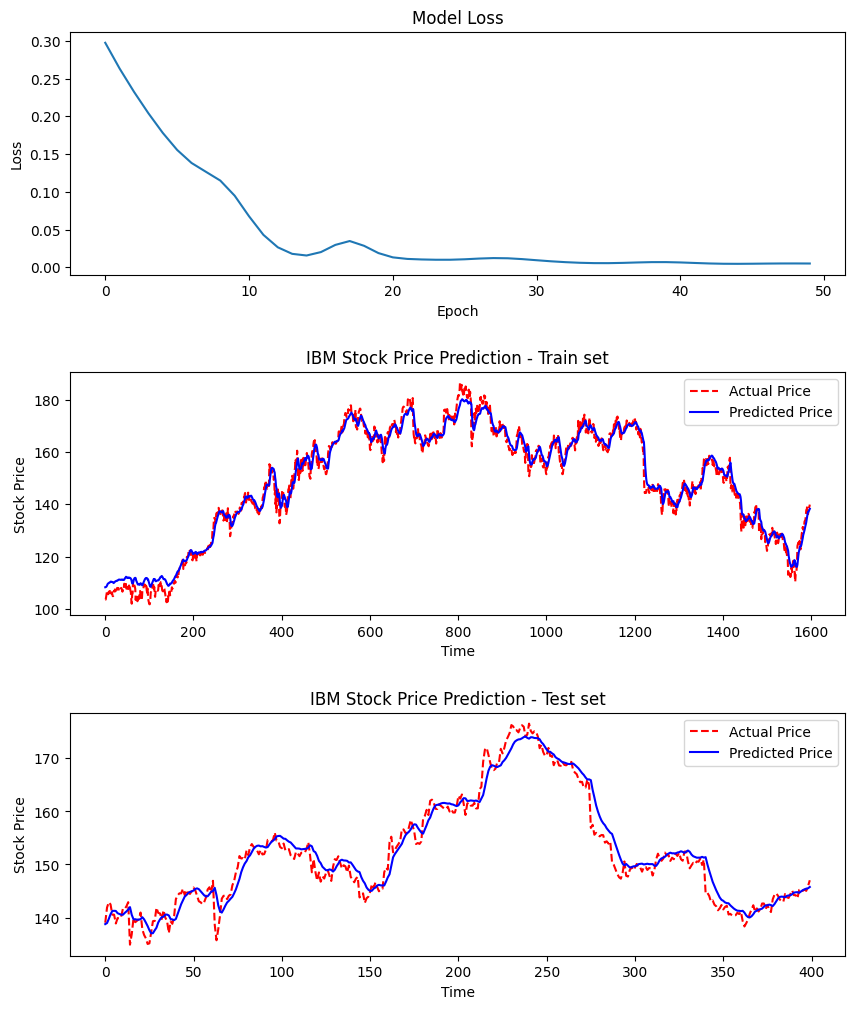

In [143]:
# plot the loss along epochs
# use `model_performance` function to show results
# (see example below, it does not have to be exactly equal, you can build your own)
num_epochs = 50
model_performance(y_train, prediction_train, y_test, prediction_test, num_epochs)

Train score: 2.7356 RMSE
Test score: 2.0979 RMSE



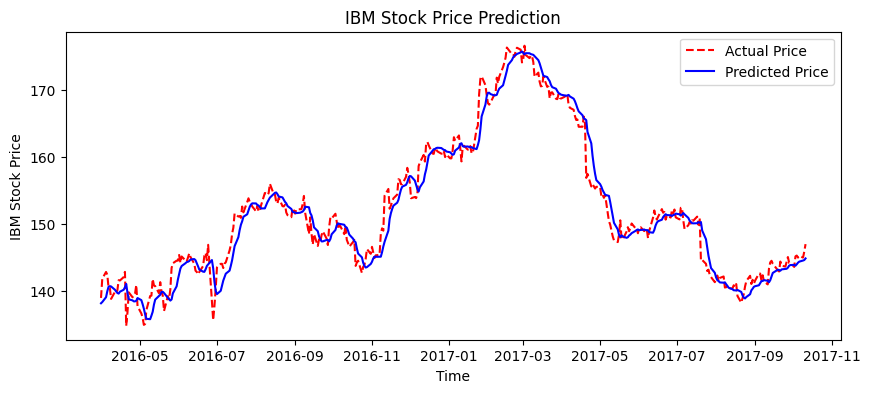

# 5 **Experiments**



## **Task 5** (3 pts) using as basis the implemented model, perform an experiment as follows:

1. Change the optimization function to `AdamW` and the loss function to MAE (mean absolute error), which is implemented in torch by the `L1Loss` class. In all experiments use 30 epochs and Learning Rate = 0.0025

2. Execute experiments with the following architectural configurations:
- 1 Hidden Layer, 4 LSTM units
- 1 Hidden Layer, 16 LSTM units
- 1 Hidden Layer, 32 LSTM units
- 3 Hidden Layers, 4 LSTM units
- 3 Hidden Layers, 16 LSTM units
- 3 Hidden Layers, 32 LSTM units

3. From the experiments, draw some conclusions about the varying architectural configurations (in the end of the notebook)

LSTM units: 4 Number of Layers: 1
RMSE Train score: 20.71689
RMSE Test score: 9.627625


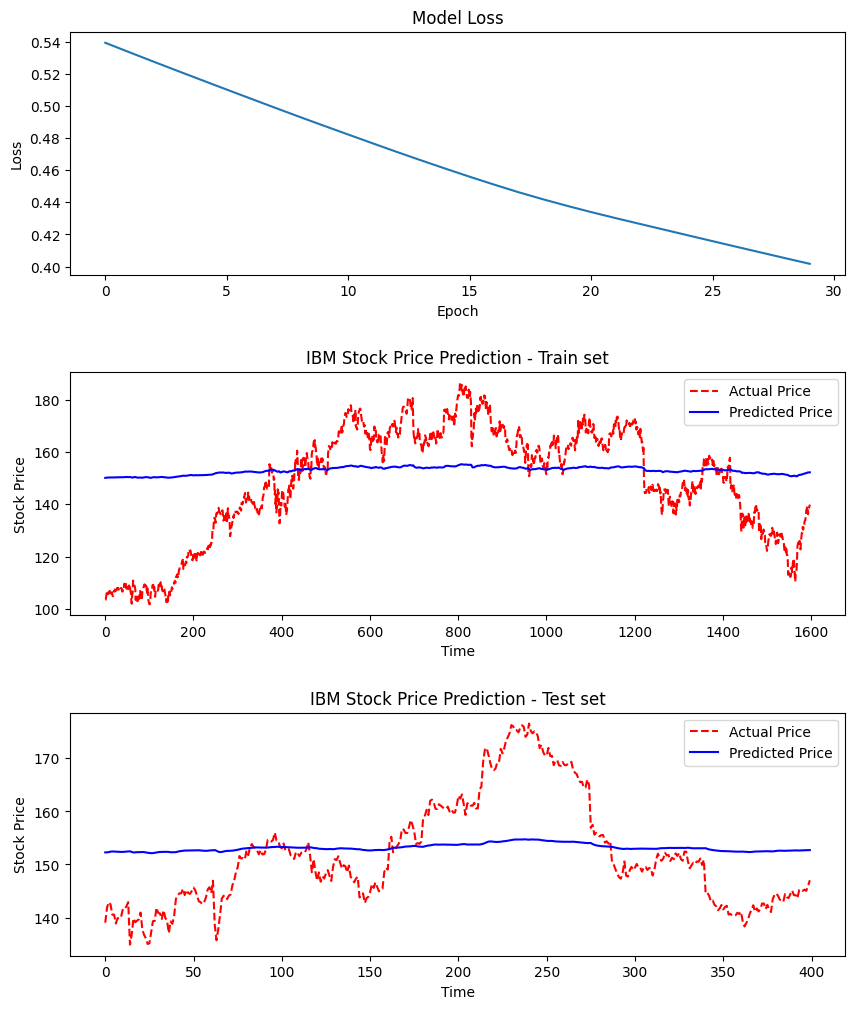

LSTM units: 16 Number of Layers: 1
RMSE Train score: 14.524595
RMSE Test score: 6.807391


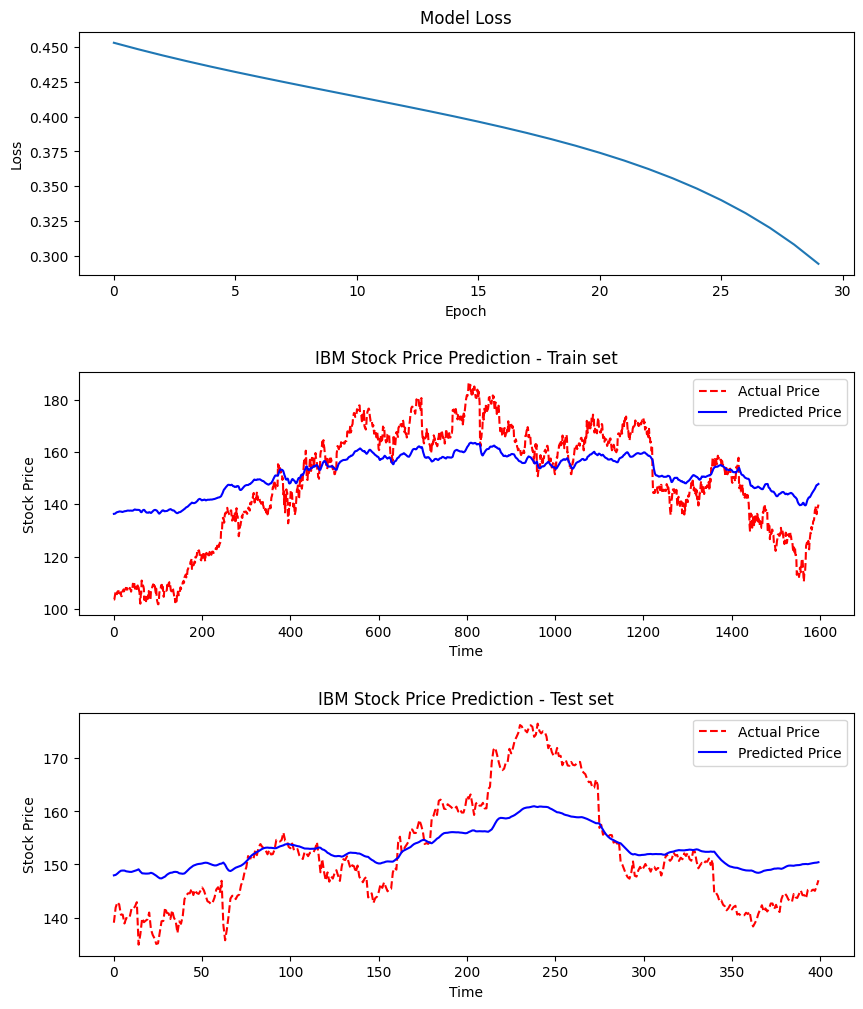

LSTM units: 32 Number of Layers: 1
RMSE Train score: 4.2070074
RMSE Test score: 3.0883386


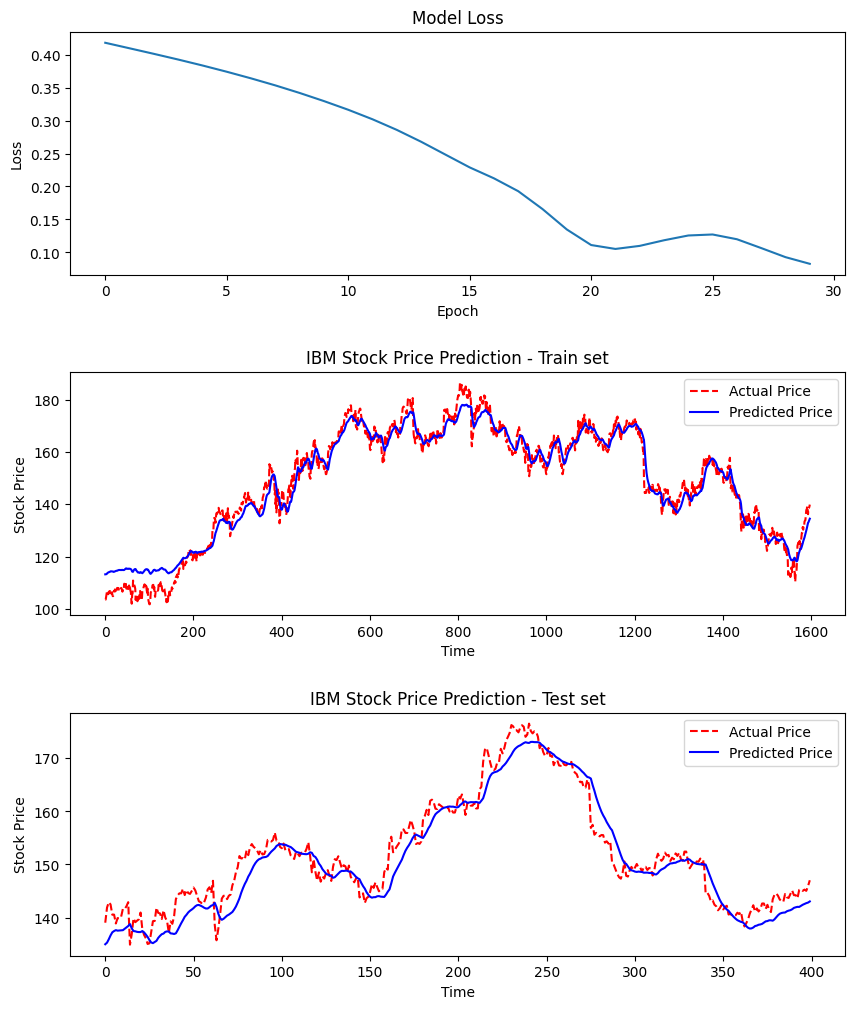

LSTM units: 4 Number of Layers: 3
RMSE Train score: 21.988918
RMSE Test score: 10.21594


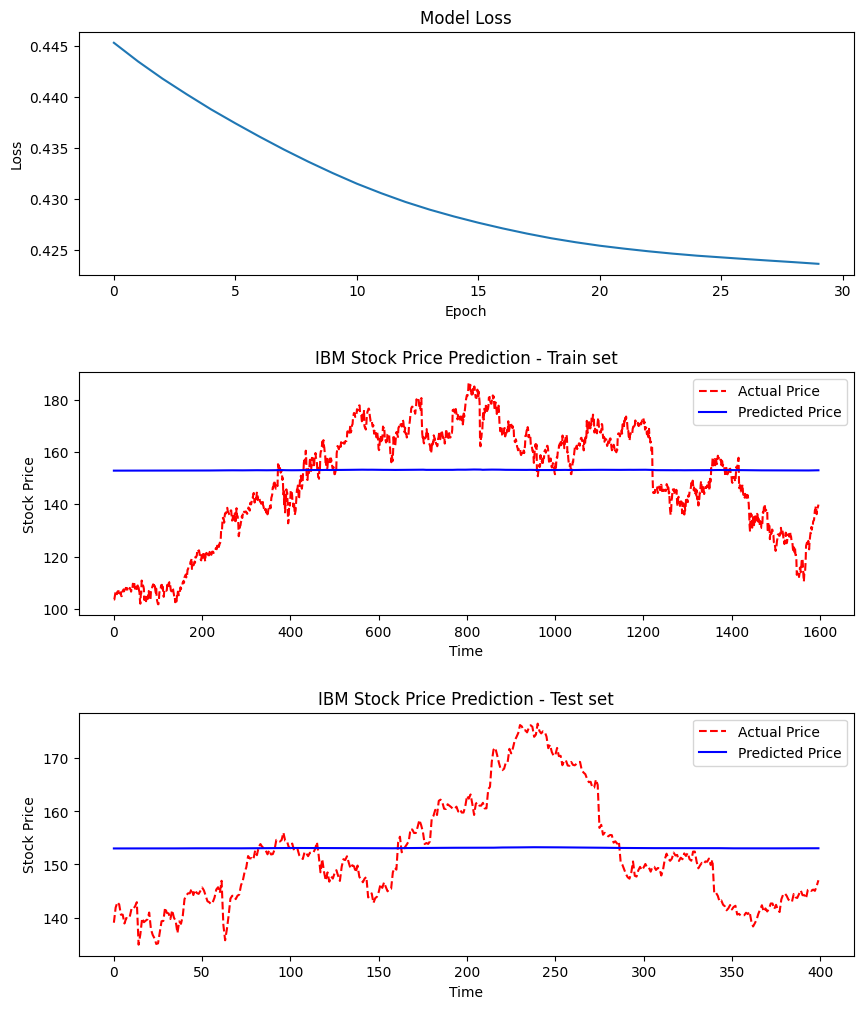

LSTM units: 16 Number of Layers: 3
RMSE Train score: 9.562855
RMSE Test score: 5.9085975


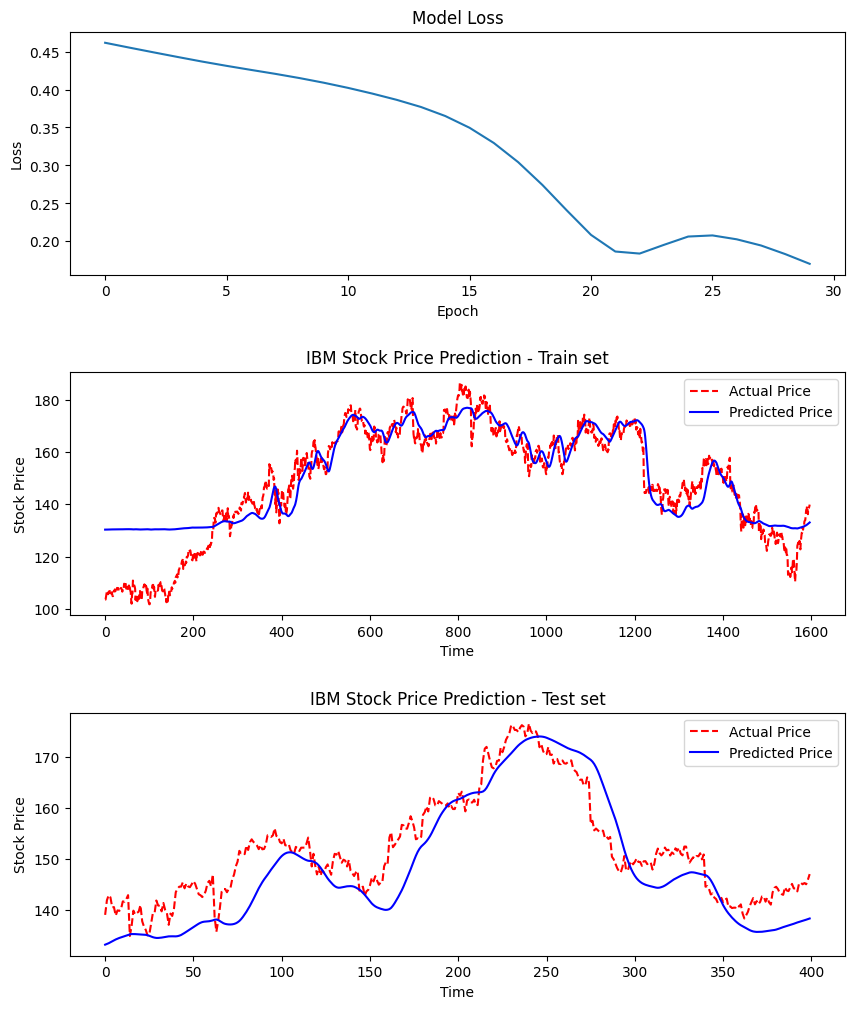

LSTM units: 32 Number of Layers: 3
RMSE Train score: 9.242169
RMSE Test score: 5.544238


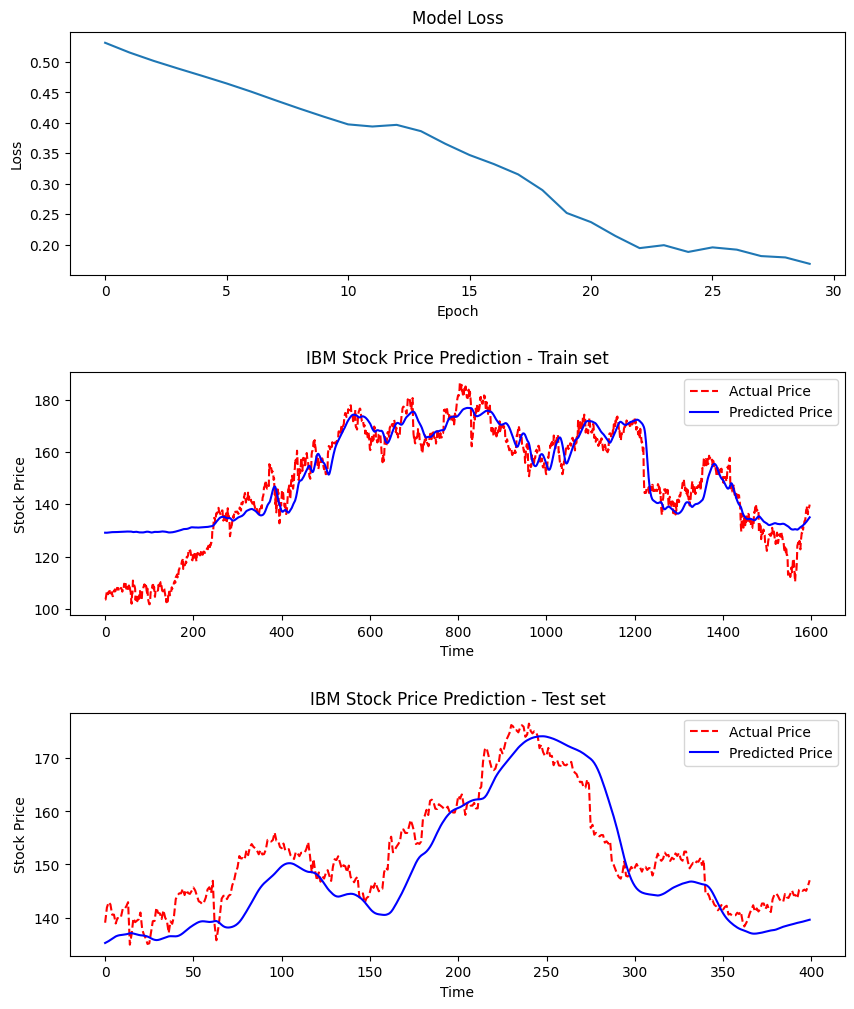

In [144]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=UserWarning)

input_dim = 1
output_dim = 1

hidden_sizes = [4, 16, 32, 4, 16, 32]  #lstm units
num_layers_values = [1, 1, 1, 3, 3, 3] #number of layers

epochs = 30
lr = 0.0025

for hidden_size, num_layers in zip(hidden_sizes, num_layers_values):
  ## run experiments

  ## instantiate the model and print it
  model = LSTM_base(input_dim, hidden_size, num_layers, output_dim)
  #print(model)

  ## training
  loss_function = nn.L1Loss() #MAE: Mean Absolute Error
  optimizer = torch.optim.AdamW(model.parameters(), lr)
  history_train, prediction_train, prediction_test = training_and_evaluate(model, epochs, loss_function, optimizer, x_train, y_train, x_test, verbose=False)

  ## visualizing results
  print('LSTM units:', hidden_size, 'Number of Layers:', num_layers)
  model_performance(y_train, prediction_train, y_test, prediction_test, epochs)

>> Re-running the experiments, to plot the results side-by-side for the test set.

In [145]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np

def model_performance2(y_train, y_hat_train, y_test, y_hat_test, num_epochs):
    """Visualize series and predicted series, and evaluate model with RMSE
       Params:
          y_train - real training series
          y_hat_train - predicted training series
          y_test - real testing series
          y_hat_test - predicted training series
    """
    # Apply the reverse transformation on the data
    y_hat_train_rev = scaler.inverse_transform(y_hat_train.detach().numpy()) #complete
    ## complete with your code here
    y_hat_test_rev = scaler.inverse_transform(y_hat_test.detach().numpy())

    y_train_rev = scaler.inverse_transform(y_train.detach().numpy())
    y_test_rev = scaler.inverse_transform(y_test.detach().numpy())

    # Calculate and print root mean squared error (RMSE)
    # training data
    rmse_train = np.sqrt(mean_squared_error(y_hat_train_rev, y_train_rev))
    # testing data
    rmse_test = np.sqrt(mean_squared_error(y_hat_test_rev, y_test_rev))

    #print('RMSE Train score:', rmse_train)
    #print('RMSE Test score:', rmse_test)

    return rmse_train, rmse_test, y_hat_test_rev, y_test_rev

In [148]:
# Experiments

input_dim = 1
output_dim = 1

hidden_sizes = [4, 16, 32, 4, 16, 32]  #lstm units
num_layers_values = [1, 1, 1, 3, 3, 3] #number of layers

epochs = 30
lr = 0.0025

# save data
history_trains = []
prediction_tests = []  #rev
prediction_trains = []
rmse_trains = []
rmse_tests = []
#y_tests_rev = [] #rev: um só!

for hidden_size, num_layers in zip(hidden_sizes, num_layers_values):
  ## run experiments

  ## instantiate the model and print it
  model = LSTM_base(input_dim, hidden_size, num_layers, output_dim)
  #print(model)

  ## training
  loss_function = nn.L1Loss() #MAE: Mean Absolute Error
  optimizer = torch.optim.AdamW(model.parameters(), lr)
  history_train, prediction_train, prediction_test = training_and_evaluate(model, epochs, loss_function, optimizer, x_train, y_train, x_test, verbose=False)

  ## saving results (only test sets)
  history_trains.append(history_train)

  rmse_train, rmse_test, y_hat_test_rev, y_test_rev = model_performance2(y_train, prediction_train, y_test, prediction_test, epochs)
  rmse_trains.append(rmse_train)
  rmse_tests.append(rmse_test)

  prediction_tests.append(y_hat_test_rev) #prediction


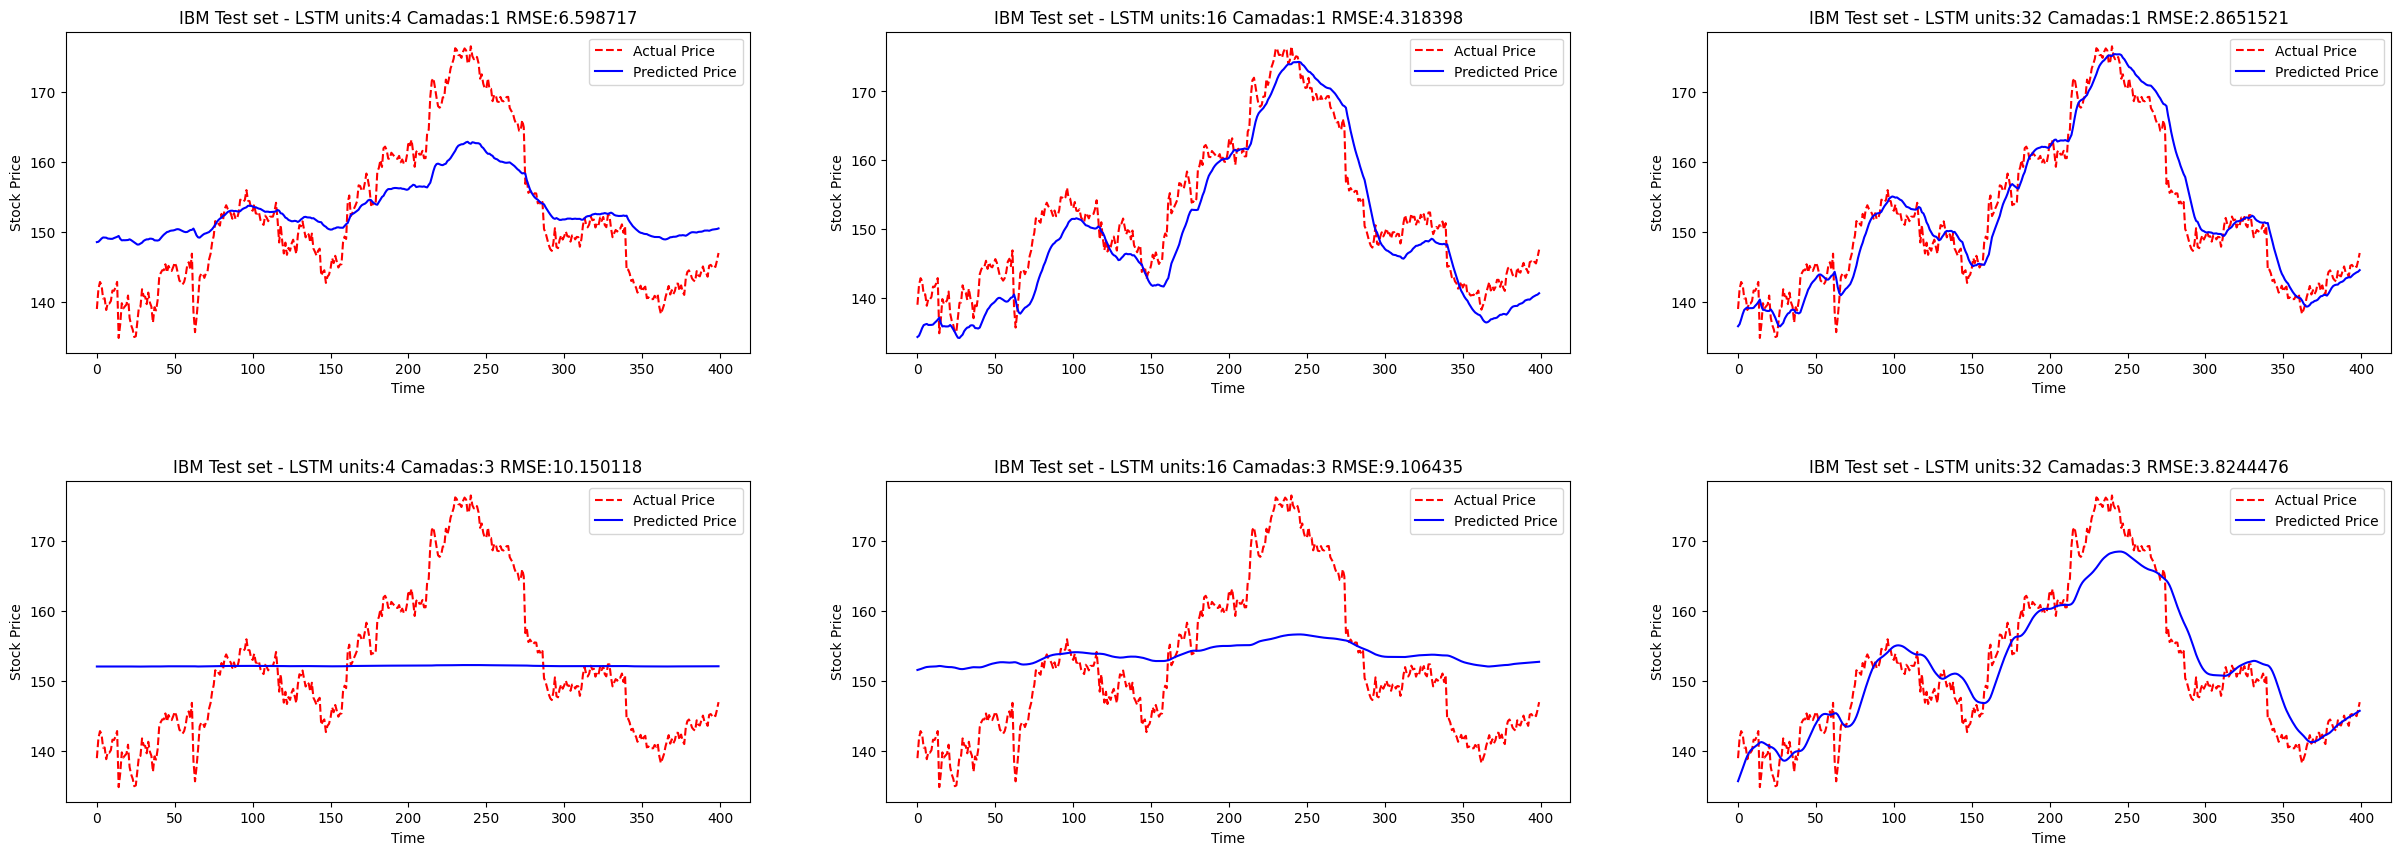

In [149]:
# Visualizing results: test set
fig, axs = plt.subplots(2,3, figsize=(30, 10))
plt.subplots_adjust(hspace= 0.4)

axs[0,0].plot(y_test_rev, ls='--', color='red') #real value
axs[0,0].plot(prediction_tests[0], color='blue')    #prediction
axs[0,0].set_xlabel('Time')
axs[0,0].set_ylabel('Stock Price')
axs[0,0].legend(['Actual Price', 'Predicted Price'])
title = 'IBM Test set - LSTM units:' + str(hidden_sizes[0]) + ' Camadas:' + str(num_layers_values[0]) + ' RMSE:' + str(rmse_tests[0])
axs[0,0].set_title(title)

axs[0,1].plot(y_test_rev, ls='--', color='red') #real value
axs[0,1].plot(prediction_tests[1], color='blue')    #prediction
axs[0,1].set_xlabel('Time')
axs[0,1].set_ylabel('Stock Price')
axs[0,1].legend(['Actual Price', 'Predicted Price'])
title = 'IBM Test set - LSTM units:' + str(hidden_sizes[1]) + ' Camadas:' + str(num_layers_values[1]) + ' RMSE:' + str(rmse_tests[1])
axs[0,1].set_title(title)

axs[0,2].plot(y_test_rev, ls='--', color='red') #real value
axs[0,2].plot(prediction_tests[2], color='blue')    #prediction
axs[0,2].set_xlabel('Time')
axs[0,2].set_ylabel('Stock Price')
axs[0,2].legend(['Actual Price', 'Predicted Price'])
title = 'IBM Test set - LSTM units:' + str(hidden_sizes[2]) + ' Camadas:' + str(num_layers_values[2]) + ' RMSE:' + str(rmse_tests[2])
axs[0,2].set_title(title)

axs[1,0].plot(y_test_rev, ls='--', color='red') #real value
axs[1,0].plot(prediction_tests[3], color='blue')    #prediction
axs[1,0].set_xlabel('Time')
axs[1,0].set_ylabel('Stock Price')
axs[1,0].legend(['Actual Price', 'Predicted Price'])
title = 'IBM Test set - LSTM units:' + str(hidden_sizes[3]) + ' Camadas:' + str(num_layers_values[3]) + ' RMSE:' + str(rmse_tests[3])
axs[1,0].set_title(title)

axs[1,1].plot(y_test_rev, ls='--', color='red') #real value
axs[1,1].plot(prediction_tests[4], color='blue')    #prediction
axs[1,1].set_xlabel('Time')
axs[1,1].set_ylabel('Stock Price')
axs[1,1].legend(['Actual Price', 'Predicted Price'])
title = 'IBM Test set - LSTM units:' + str(hidden_sizes[4]) + ' Camadas:' + str(num_layers_values[4]) + ' RMSE:' + str(rmse_tests[4])
axs[1,1].set_title(title)

axs[1,2].plot(y_test_rev, ls='--', color='red') #real value
axs[1,2].plot(prediction_tests[5], color='blue')    #prediction
axs[1,2].set_xlabel('Time')
axs[1,2].set_ylabel('Stock Price')
axs[1,2].legend(['Actual Price', 'Predicted Price'])
title = 'IBM Test set - LSTM units:' + str(hidden_sizes[5]) + ' Camadas:' + str(num_layers_values[5]) + ' RMSE:' + str(rmse_tests[5])
axs[1,2].set_title(title)

plt.show()

### **Conclusions/Remarks** from the experiment results

- Os experimentos permitiram explorar e ter uma ideia do desempenho das redes LSTM para diferentes arquiteturas. De modo geral, pode-se observar que para uma mesma quantidade de camadas, o modelo tende a se sair melhor conforme o número de unidades LSTM aumenta:
  - Para redes de 1 camada, o modelo com 32 unidades LSTM apresentou o menor RMSE: 2.865
  - Para redes de 3 camadas, o modelo com 32 unidades LSTM apresentou o menor RMSE: 3.824
- Por outro lado, os experimentos conduzidos com os valores de número de unidades LSTM (4, 16, 32) e camadas (1, 3) - para os número de epochs e learning rate dados - levam a crer que um maior número de camadas não implica necessariamente em um melhor desempenho, que pode ser quantitativamente mensurado pelo valor do erro RMSE:
  - 4 unidades LSTM: RMSE 1 camada = 6.598 < RMSE 3 camadas = 10.150
  - 16 unidades LSTM: RMSE 1 camada = 4.318 < RMSE 3 camadas = 9.106
  - 32 unidades LSTM: RMSE 1 camada = 2.865 < RMSE 3 camadas = 3.824
- Para as condições testadas, no conjunto de teste, o modelo que se saiu malhor na tarefa foi o com a arquitetura 32 LSTM units e 1 camada.  

Em suma, no trabalho foi possível lidar com a implementação das redes LSTM para lidar com dados sequenciais, no caso, uma série temporal do preço de uma ação, e ver como esse tipo de rede pode ser bem sucedido na tarefa de previsão de valor futuro.